<a href="https://colab.research.google.com/github/tqthanhcong/streamlit-example/blob/master/o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
import seaborn as sns

In [ ]:
#load data
df_services = pd.read_csv("services.csv",parse_dates=["Date"])
df_user_info = pd.read_csv("user_services.csv",parse_dates=["FirstServiceDate","SecondServiceDate","LastServiceDate"])
df = df_services.merge(df_user_info,how="left",on="User_id")
df["age"] = (df["LastServiceDate"] - df["FirstServiceDate"]).dt.days
df["Serviceid"]=df["Serviceid"].astype("str")
df.head(3)

,Serviceid,Date,User_id,FirstServiceId,SecondServiceId,FirstServiceDate,SecondServiceDate,LastServiceId,LastServiceDate,TotalService,age
0,20,2018-01-02,40709217,20,20,2018-01-02,2018-01-02,20,2018-01-02,1,0
1,20,2018-01-02,40709217,20,20,2018-01-02,2018-01-02,20,2018-01-02,1,0
2,984,2018-03-22,18246539,984,269,2018-03-22,2018-03-22,326,2018-04-01,4,10


# Part 2 - Analysis Test 1

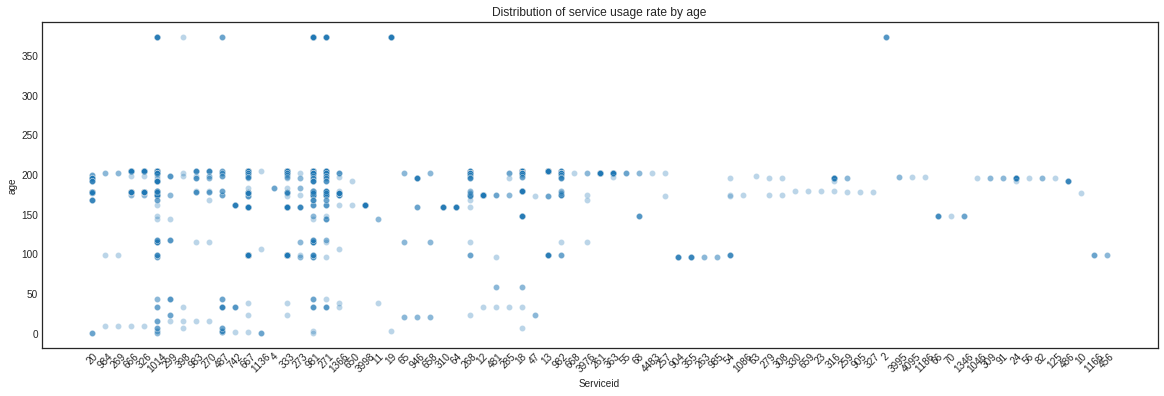

In [ ]:
#quick check if there is a focus on a few products at different ages
plt.figure(figsize=(20,6))
sns.scatterplot(data=df,x="Serviceid",y="age",alpha=0.3)
#plt.scatter(df["Serviceid"],df["age"],alpha=0.3)
plt.xticks(rotation=45)
plt.title("Distribution of service usage rate by age")
plt.show()

Yes, there are many products that low-age users do not use or use little while high-age users do. So we have to make some deeper analysis

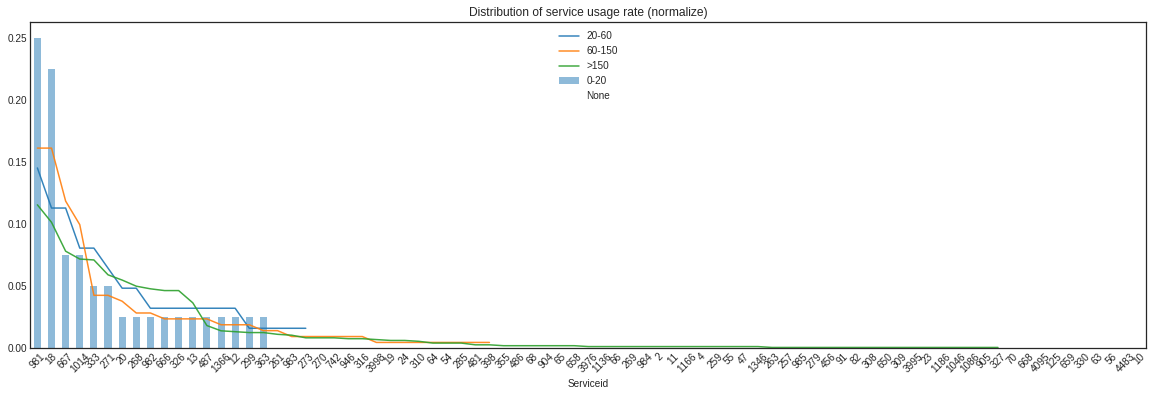

In [ ]:
#fig,ax=plt.subplots(2,sharex=True,sharey=True,figsize=(30,15))
subset0=df["age"]<20
subset1=(df["age"]>=20)&(df["age"]<60)
subset2=(df["age"]>=60)&(df["age"]<150)
subset3=df["age"]>150

plt.figure(figsize=(20,6))
df[subset0].value_counts("Serviceid",normalize=True).plot(kind="bar",alpha=0.5,label="0-20")
df[subset1].value_counts("Serviceid",normalize=True).plot(kind="line",alpha=0.9,label="20-60")
df[subset2].value_counts("Serviceid",normalize=True).plot(kind="line",alpha=0.9,label="60-150")
df[subset3].value_counts("Serviceid",normalize=True).plot(kind="line",alpha=0.9,label=">150")
df.value_counts("Serviceid",normalize=True).plot(kind="bar",alpha=0)
plt.xticks(rotation=45)
plt.title("Distribution of service usage rate (normalize)")
plt.legend(loc="upper center")
plt.show()

But how about distinct user?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


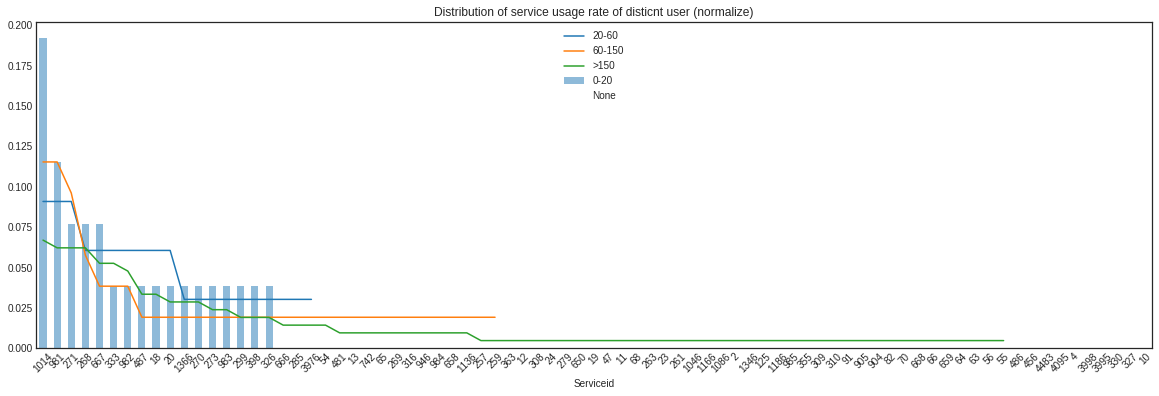

In [ ]:
#distinct user & service
df_distinct = df[["Serviceid","User_id","age"]]
df_distinct.drop_duplicates(subset=["Serviceid","User_id"],inplace=True,ignore_index=True)

#plot
subset0=df_distinct["age"]<20
subset1=(df_distinct["age"]>=20)&(df_distinct["age"]<60)
subset2=(df_distinct["age"]>=60)&(df_distinct["age"]<150)
subset3=df_distinct["age"]>150

plt.figure(figsize=(20,6))
df_distinct[subset0].value_counts("Serviceid",normalize=True).plot(kind="bar",alpha=0.5,label="0-20")
df_distinct[subset1].value_counts("Serviceid",normalize=True).plot(kind="line",label="20-60")
df_distinct[subset2].value_counts("Serviceid",normalize=True).plot(kind="line",label="60-150")
df_distinct[subset3].value_counts("Serviceid",normalize=True).plot(kind="line",label=">150")
df_distinct.value_counts("Serviceid",normalize=True).plot(kind="bar",alpha=0)
plt.xticks(rotation=45)
plt.title("Distribution of service usage rate of disticnt user (normalize)")
plt.legend(loc="upper center")
plt.show()


the results are similar. new users use a lot of services 1014, 981, 271, 268 (group 1). Users over 2 months - half a year start using new services but still maintain a good level of usage of group 1 services. high. However, users over 5 months start using the products more evenly and expand to products that the new users don't use.

# Part 2 - Analysis test - 2

In [ ]:
#cross join to pair the services
df_2 = df_distinct[["Serviceid","User_id"]]
df_cross = df_2.merge(df_2,on="User_id")
df_cross = df_cross[df_cross["Serviceid_x"]!=df_cross["Serviceid_y"]]
print(len(df_cross))
print(df_cross.head(2))

3200
  Serviceid_x   User_id Serviceid_y
2         984  18246539         269
3         984  18246539         666


These are service pairs used by the same user

In [ ]:
#count distinct user that use a service and count distinct user use that service + another service
df_count_all = df_2.value_counts("Serviceid").to_frame()
df_count_cross=df_cross[["Serviceid_x","User_id"]].groupby("Serviceid_x").User_id.nunique()
df_count_user = df_count_all.merge(df_count_cross,left_index=True,right_index=True)
df_count_user.columns=["total_count","cross_count"]
df_count_user.head(2)


,total_count,cross_count
1014,27,27
981,25,25


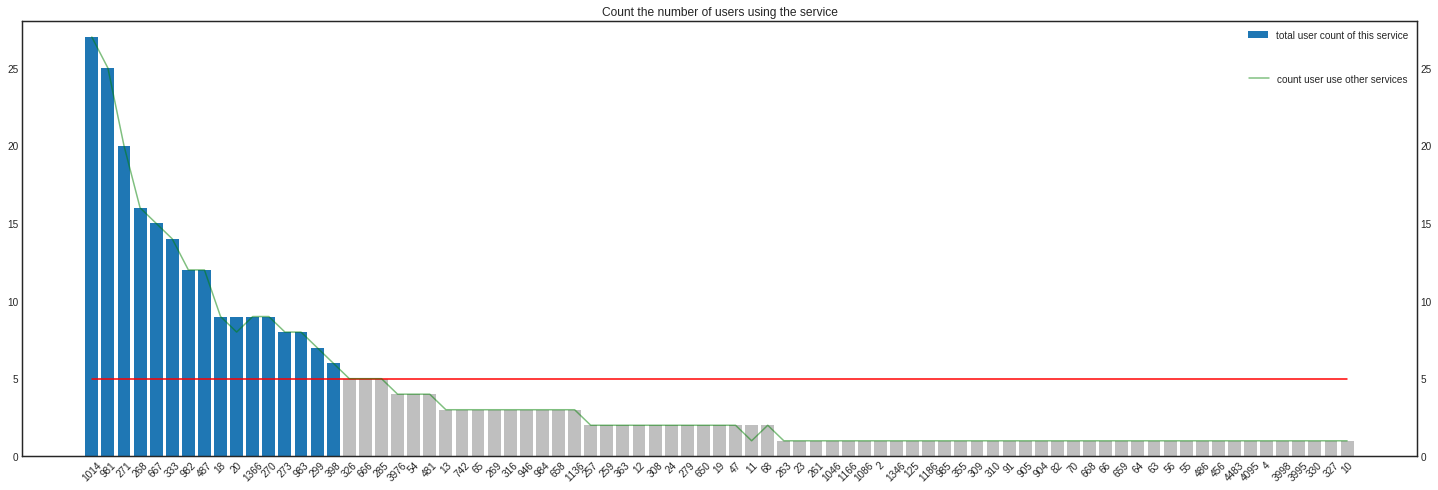

In [ ]:
#plot
fig,ax = plt.subplots(figsize=(25,8),sharey=True)
plt.xticks(rotation=45)

subset1 = df_count_user["total_count"]>5
subset2 = df_count_user["total_count"]<=5
ax.bar(df_count_user[subset1].index,df_count_user[subset1]["total_count"],label="total user count of this service")
ax.bar(df_count_user[subset2].index,df_count_user[subset2]["total_count"],alpha=0.5,color="gray")

ax2=ax.twinx()
ax2.plot(df_count_user.index,df_count_user["cross_count"],label="count user use other services",color="green",alpha=0.5)
ax.plot(df_count_user.index,[5]*len(df_count_user),color="red")

ax.set_ylim(0,df_count_user["total_count"].max()+1)
ax2.set_ylim(0,df_count_user["total_count"].max()+1)
ax.legend(bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
ax2.legend(bbox_to_anchor=(0.5, 0.4, 0.5, 0.5))


plt.title("Count the number of users using the service")
plt.show()

In [ ]:
df_count_user[df_count_user.index=="261"]

,total_count,cross_count
261,1,1


In [ ]:
#cross merge service/user to find services were used by the same user
df_cross_count = df_cross.value_counts(subset=["Serviceid_x","Serviceid_y"]).to_frame()
df_cross_count.reset_index(drop=False,inplace=True)
df_cross_count.columns=["Serviceid","Serviceid_cross_sale","count"]
df_cross_count.head(2)

,Serviceid,Serviceid_cross_sale,count
0,1014,981,24
1,981,1014,24


In [ ]:
#product pairs used by the same user
df_count = df_cross_count[df_cross_count["count"]>5]
df_count = df_count.merge(df_merge_count["total_count"],left_on="Serviceid",right_index=True)
df_count["level_cross_sale"]=df_count["count"]/df_count["total_count"]
df_count.sort_values("level_cross_sale",ascending=False,inplace=True)
df_count.head(2)

,Serviceid,Serviceid_cross_sale,count,total_count,level_cross_sale
68,398,1014,6,6,1.0
38,983,1014,8,8,1.0


This table show there are 6 users use service 398 and all of them used service 1014 so the level_cross_sall is 1 (100%)

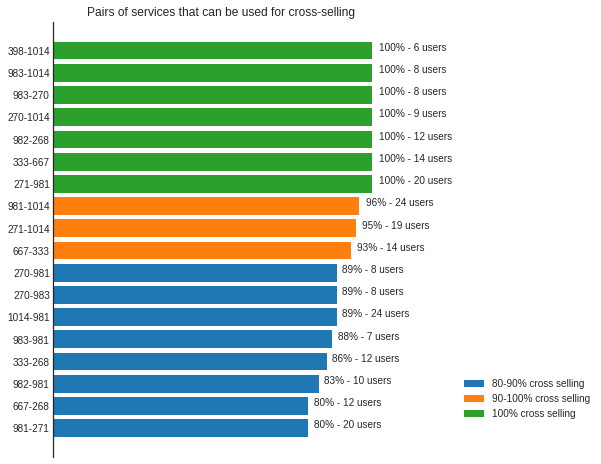

In [ ]:
#product pair with high level cross selling
df_high_level_cross = df_pair_count[df_pair_count["level_cross_sale"]>=0.8]

plt.figure(figsize=(6,8))

ys=df_high_level_cross["Serviceid"] + "-" + df_high_level_cross["Serviceid_cross_sale"]
xs = df_high_level_cross["level_cross_sale"]
zs = df_high_level_cross["count"]

plt.barh(ys,xs,label = "80-90% cross selling")
plt.barh(ys[xs>0.9],xs[xs>0.9], label = "90-100% cross selling")
plt.barh(ys[xs==1],xs[xs==1], label = "100% cross selling")

for y,x,z in zip(ys,xs,zs):  #label
  label = "{percent:.0f}% - {count} users".format(percent=x*100,count=z)
  plt.annotate(label,(x*1.02,y))

plt.gca().spines['right'].set_visible(False) #format, remove border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().get_xaxis().set_ticks([])
plt.gca().invert_yaxis()
plt.legend(loc="best",bbox_to_anchor=(1.2, 0.2))
plt.title("Pairs of services that can be used for cross-selling")
plt.show()

Text(0.5, 1.0, '% cross-sale')

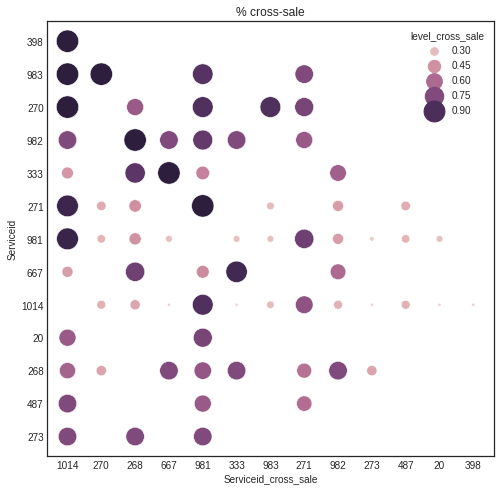

In [ ]:
#df_high_level_cross = df_pair_count[df_pair_count["level_cross_sale"]>=0.8]
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_pair_count,x="Serviceid_cross_sale",y="Serviceid",hue="level_cross_sale",size="level_cross_sale",sizes=(10,500),legend="auto")
plt.title("% cross-sale")

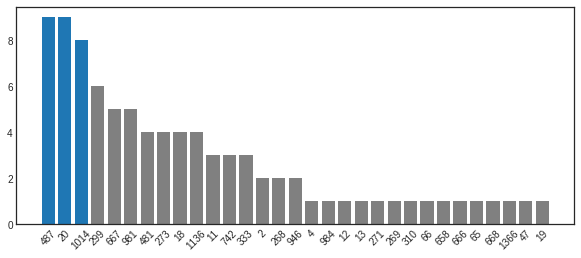

In [ ]:
#Find out which services are most used by users for the first time or second time. These services will probably appear more in pairs with a high probability of cross-selling. So pay attention to these services
data_plot = pd.concat([df_user_info["FirstServiceId"],df_user_info["SecondServiceId"]]).value_counts()
data_plot.index = data_plot.index.astype("str")

plt.figure(figsize=(10,4))
plt.bar(data_plot[:3].index,data_plot[:3].values)
plt.bar(data_plot[3:].index,data_plot[3:].values,color="gray")
plt.xticks(rotation=45)
plt.show()

# Part 2 - 2

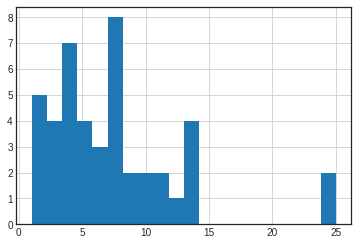

In [ ]:
count_service = df_distinct.groupby("User_id").Serviceid.count()
count_service.hist(bins=20)

In [ ]:
count_service.describe()

count    44.000000
mean      7.272727
std       5.266673
min       1.000000
25%       4.000000
50%       6.000000
75%       9.250000
max      25.000000
Name: Serviceid, dtype: float64

In [ ]:
count_service[count_service.values>20]

User_id
36301869    25
40708072    25
Name: Serviceid, dtype: int64

The best cross-selling products are:
983 - 270,
982 - 268,
333 - 667,
271 - 981,
all service - 1014